# Analysis of Personal Finance Bookkeeping Activity
What is the motivation for conducting this analysis?

Exploring bookkeeping of personal income and spending can reveal that...

Users who enjoy tracking their expenses and income might be,
depending on their approach and enthusiasm for financial management.
described as:

- **Budget-conscious** – Someone who carefully plans and monitors their spending.
- **Financially meticulous** – A person who pays close attention to financial details.
- **Expense tracker** – Someone who actively records their spending habits.
- **Frugal planner** – A person who enjoys optimizing their finances for savings.
- **Money-savvy** – Someone who is knowledgeable and strategic about finances.
- **Personal finance enthusiast** – A broader term for those who enjoy managing their money.
- **Data-driven spender** – Someone who makes financial decisions based on recorded data.
- **Financial optimizer** – A person who seeks to maximize efficiency in their financial habits.

On the other hand, users who don’t track their expenses and income regularly might be,
depending on their habits and attitudes toward financial management, described as such:

- **Spontaneous spender** – Someone who makes purchases without much planning.
- **Financially carefree** – A person who doesn’t stress about tracking money closely.
- **Unstructured budgeter** – Someone who manages finances loosely without detailed records.
- **Impulse buyer** – A person who tends to make purchases on a whim.
- **Money-agnostic** – Someone who doesn’t prioritize financial tracking.
- **Casual earner** – A person who earns and spends without strict oversight.
- **Non-budgeter** – Someone who avoids formal budgeting altogether.
- **Financially intuitive** – A person who relies on instinct rather than detailed tracking.

# Data Source

- acc_user
- acc_cashflow

In [1]:
import os
from sqlalchemy import create_engine
import pandas as pd

user = os.getenv("MYSQL_USER")
password = os.getenv("MYSQL_PASSWORD")
host = "localhost"
database = "zoo"

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")

## User Registration Date

In [2]:
## user registration , i.e. account creation, date

query = """
SELECT
  user_id,
  isBot is_bot,
  min(DATE(CREDTM)) registered
FROM zoo_checkchick2.ACC_USER
GROUP BY user_id, is_bot
"""

users = pd.read_sql(query, con=engine,
                    dtype=({'is_bot':'bool', 'registered':'datetime64[ns]'}))
users.describe()

,registered
count,651992
mean,2020-02-18 09:02:58.765383936
min,2018-06-01 00:00:00
25%,2018-11-06 00:00:00
50%,2019-07-30 00:00:00
75%,2021-01-06 00:00:00
max,2025-02-08 00:00:00


In [3]:
# how many Bots?
print(users.is_bot.sum())

199


<Axes: xlabel='registered_yr'>

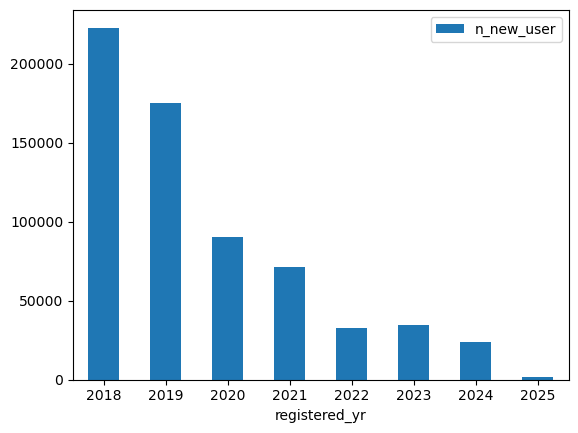

In [4]:
# user cohorts by registered year

query = """
SELECT
  year(CREDTM) registered_yr,
  count(*) n_new_user
FROM (
  SELECT
    USER_ID,
    min(CREDTM) AS CREDTM
  FROM zoo_checkchick2.ACC_USER
  GROUP BY USER_ID
) foo
  GROUP BY registered_yr
  ORDER BY registered_yr
;
"""

pd.read_sql(query, con=engine).plot.bar(x='registered_yr', y='n_new_user', rot=0)

## Cashflow

               total  nbr_expense_entry  nbr_group_entry
count     170.000000         170.000000       170.000000
mean   207616.941176      194336.658824     32174.147059
std    228406.501617      214520.345511     36185.704552
min         1.000000           0.000000         0.000000
25%         3.000000           3.000000         0.000000
50%       232.500000         170.500000        44.500000
75%    416924.000000      386208.000000     65632.750000
max    841703.000000      818109.000000    102861.000000


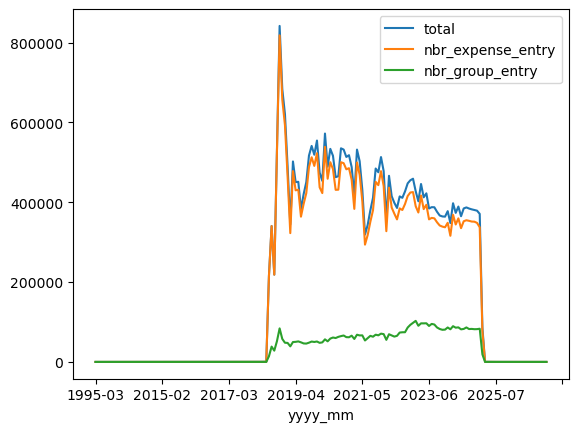

In [5]:
# check number of records (expense and income entries) each month

query = """
SELECT DATE_FORMAT(date, '%%Y-%%m') yyyy_mm,
  COUNT(*) total,
  SUM(is_expense) nbr_expense_entry,
  SUM(is_group) nbr_group_entry
FROM zoo.acc_cashflow
GROUP BY yyyy_mm
"""

df = pd.read_sql(query, con=engine)
print(df.describe())
_ = df.plot.line(x='yyyy_mm', y=['total', 'nbr_expense_entry', 'nbr_group_entry'])

__*Observation:*__
- errorenous timestamps
- personal entries makes up significally larger portions of records; I had expected more entries. 
- expenses makes up larger portion of the records; this aligns with the norm for personal finance dataset.

In [6]:
# acc_cashflow dataset
# left and right date range censored 
# between '2018-06-01' AND '2025-01-31'
# to exclude erroneous rows

cashflow = pd.read_feather('../data/cashflow.feather'
                          ).query("'2018-06-01' <= date <= '2025-01-31'")
cashflow.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35205617 entries, 0 to 35294856
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      object        
 1   date         datetime64[ns]
 2   amt          float64       
 3   is_expense   bool          
 4   is_group     bool          
 5   group_id     object        
 6   category_id  int64         
 7   category     object        
 8   note         object        
dtypes: bool(2), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 2.2+ GB


_**n.b.,**_ __amt__ is float64. _I expect this to be whole number._

In [7]:
cashflow.isna().sum()

user_id               0
date                  0
amt                   0
is_expense            0
is_group              0
group_id       29755562
category_id           0
category         785454
note                  0
dtype: int64

In [8]:
print(cashflow.group_id.count() / cashflow.shape[0])

0.15480640489840017


_**Observation:**_ group entries make up about 15% of the records.

_**Question:**_ Should factional amounts be rounded up?

In [9]:
# should amt be whole number?
bad = cashflow.query("amt % 1 != 0").copy()
bad.describe()

,date,amt,category_id
count,130958,1.309580e+05,130958.000000
mean,2022-08-04 07:28:22.109073152,-3.658672e+02,2833.819492
min,2018-06-21 00:00:00,-2.222222e+07,0.000000
25%,2021-04-14 00:00:00,-4.160000e+01,1.000000
50%,2022-11-16 00:00:00,-1.340000e+01,2.000000
75%,2024-01-05 00:00:00,-4.152500e+00,5.000000
max,2025-01-31 00:00:00,1.000000e+07,75967.000000
std,NaN,9.389124e+04,10857.694536


In [10]:
# create quartile bins
bad['quartile'] = pd.qcut(bad['amt'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
bad.groupby('quartile', observed=True).agg({'amt':['count', 'sum', 'mean']})

amt                           
          count           sum         mean
quartile                                  
Q1        32784 -7.720933e+07 -2355.091667
Q2        32775 -7.892596e+05   -24.081147
Q3        32659 -2.640294e+05    -8.084430
Q4        32740  3.034938e+07   926.981693

In [11]:
bad.groupby(['quartile', 'is_expense'], observed=True).agg({'amt':'sum'}).unstack(level=1)

amt              
is_expense         False         True 
quartile                              
Q1                   NaN -7.720933e+07
Q2                   NaN -7.892596e+05
Q3                   NaN -2.640294e+05
Q4          3.039394e+07 -4.456345e+04

In [12]:
bad['category'].unique()

array(['飲食', '日常', '交通', ..., '資源回收', 'IG', '欠瑜'],
      shape=(1435,), dtype=object)

In [13]:
bad['note'].unique()

array(['食材', '麥當勞', '茶飲料', ..., '1/10薪水', 'myki card賣出', '01/24薪水'],
      shape=(49439,), dtype=object)

In [14]:
# impute fractional amounts by rounding up if > 0 and down if < 0

cashflow['amt'] = cashflow['amt'].round().astype('Int64')

In [15]:
cashflow.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35205617 entries, 0 to 35294856
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      object        
 1   date         datetime64[ns]
 2   amt          Int64         
 3   is_expense   bool          
 4   is_group     bool          
 5   group_id     object        
 6   category_id  int64         
 7   category     object        
 8   note         object        
dtypes: Int64(1), bool(2), datetime64[ns](1), int64(1), object(4)
memory usage: 2.2+ GB


In [16]:
# Should amount equals 0 be excluded?

cashflow[cashflow.amt == 0].count()

user_id        4620
date           4620
amt            4620
is_expense     4620
is_group       4620
group_id        233
category_id    4620
category       4541
note           4620
dtype: int64

In [17]:
# check number of active users in each month, i.e. period

cashflow['yyyy_mm'] = cashflow['date'].dt.to_period('M')
cashflow['yyyy'] = cashflow['date'].dt.year
cashflow['mm'] = cashflow['date'].dt.month

#cashflow.groupby(['yyyy', 'mm']).agg({'user_id':'nunique'}).unstack(level=1)

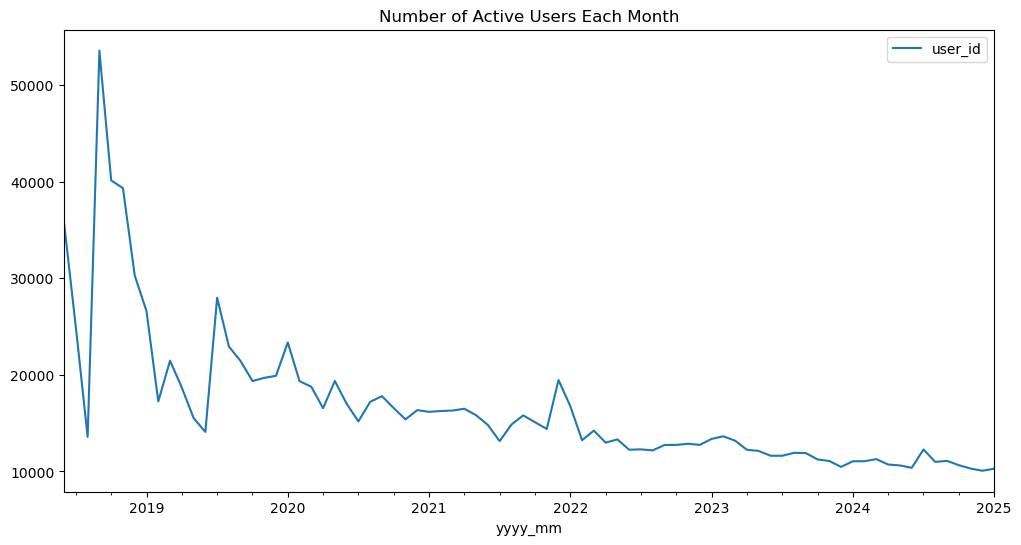

In [18]:
_ = cashflow.groupby('yyyy_mm').agg({'user_id':'nunique'}) \
    .plot(y='user_id', kind='line', figsize=(12, 6), title="Number of Active Users Each Month")

__*Observation:*__ number of active users gradually declined but not obvious

In [19]:
cashflow.describe()

,date,amt,category_id,yyyy,mm
count,35205617,35205617.0,3.520562e+07,3.520562e+07,3.520562e+07
mean,2021-07-31 02:12:30.383510016,211.797213,1.281901e+03,2.021059e+03,6.795657e+00
min,2018-06-01 00:00:00,-99999999.0,0.000000e+00,2.018000e+03,1.000000e+00
25%,2019-12-15 00:00:00,-300.0,1.000000e+00,2.019000e+03,4.000000e+00
50%,2021-06-09 00:00:00,-106.0,1.000000e+00,2.021000e+03,7.000000e+00
75%,2023-03-02 00:00:00,-53.0,4.000000e+00,2.023000e+03,1.000000e+01
max,2025-01-31 00:00:00,99999999.0,7.610900e+04,2.025000e+03,1.200000e+01
std,NaN,389861.849207,6.982359e+03,1.924690e+00,3.531527e+00


In [20]:
bad = cashflow.group_id.str.strip().str.len() == 0  # group_id missing
bad.value_counts()

group_id
False    35205159
True          458
Name: count, dtype: int64

In [21]:
cashflow.loc[bad, 'user_id'].nunique()

61

In [22]:
# impute
cashflow.loc[bad, ['group_id', 'is_group']] = [None, False]

# Tidy Dataset

Let the final tidy dataset be `td`. Proceed the data preparation as follow:

## Tenure

In [23]:
# user tenure, income and expense entry stats,
# including group entries
# excluding amount = 0
# n.b. tenure begin when user submit first entry, and does not consider
#      when user first registered with the app

tenure = cashflow[cashflow.amt != 0] \
    .groupby('user_id') \
    .agg(user_tenure = ('date', lambda x: x.max() - x.min()),
         first_entry = ('date', 'min'),
         last_entry = ('date', 'max'),
         nbr_entry = ('user_id', 'count'),
         total_exp = ('amt', lambda x: x[x < 0].sum()),
         nbr_exp = ('amt', lambda x: x[x < 0].count()),
         total_inc = ('amt', lambda x: x[x > 0].sum()),
         nbr_inc = ('amt', lambda x: x[x > 0].count())
        )
tenure.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399110 entries, 20190114221435UXD to Ufffffd83c214154e0427c19f1a97b293
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype          
---  ------       --------------   -----          
 0   user_tenure  399110 non-null  timedelta64[ns]
 1   first_entry  399110 non-null  datetime64[ns] 
 2   last_entry   399110 non-null  datetime64[ns] 
 3   nbr_entry    399110 non-null  int64          
 4   total_exp    399110 non-null  Int64          
 5   nbr_exp      399110 non-null  Int64          
 6   total_inc    399110 non-null  Int64          
 7   nbr_inc      399110 non-null  Int64          
dtypes: Int64(4), datetime64[ns](2), int64(1), timedelta64[ns](1)
memory usage: 28.9+ MB


In [24]:
tenure.describe()

,user_tenure,first_entry,last_entry,nbr_entry,total_exp,nbr_exp,total_inc,nbr_inc
count,399110,399110,399110,399110.000000,399110.0,399110.0,399110.0,399110.0
mean,213 days 07:32:40.223497284,2020-01-10 11:32:41.883190016,2020-08-10 19:05:22.106687744,88.198735,-126604.914555,82.565581,145287.6125,5.633154
min,0 days 00:00:00,2018-06-01 00:00:00,2018-06-03 00:00:00,1.000000,-4135128073.0,0.0,0.0,0.0
25%,0 days 00:00:00,2018-10-01 00:00:00,2018-12-07 00:00:00,2.000000,-16033.0,2.0,0.0,0.0
50%,7 days 00:00:00,2019-06-29 00:00:00,2019-12-17 00:00:00,7.000000,-2336.5,7.0,0.0,0.0
75%,139 days 00:00:00,2020-10-05 00:00:00,2021-12-12 00:00:00,32.000000,-327.0,29.0,9997.5,1.0
max,2436 days 00:00:00,2025-01-31 00:00:00,2025-01-31 00:00:00,35515.000000,0.0,25720.0,5959084893.0,26923.0
std,452 days 19:06:48.118525888,NaN,NaN,417.039147,8975724.512895,382.715875,13838559.350852,102.54491


_**Initial observation:**_ Of the 399,125 users, 75% of which had **not** logged entries in the last 48~50 days 

In [25]:
cashflow.groupby(['user_id', 'is_group', 'is_expense'])['category_id'].nunique().unstack(level=[1,2], fill_value=0).describe()

is_group            False          True                          False
is_expense          True           True           False          False
count       399125.000000  399125.000000  399125.000000  399125.000000
mean             3.058220       0.525672       0.114355       0.661026
std              2.858107       1.916884       0.637028       1.205458
min              0.000000       0.000000       0.000000       0.000000
25%              1.000000       0.000000       0.000000       0.000000
50%              2.000000       0.000000       0.000000       0.000000
75%              4.000000       0.000000       0.000000       1.000000
max             59.000000      62.000000      43.000000      24.000000

_**Initial observation:**_ Is it true that entries are not well categorized by the bottom 75% of users?

## Group Bookkeeping

In [26]:
# user group expense and income entry stat per user
# add count of categories

td_grp = cashflow[(cashflow.amt != 0) & (cashflow.is_group == True)] \
    .groupby('user_id') \
    .agg(n_grp = ('group_id', 'nunique'),
         first_grp_entry = ('date', 'min'),
         last_grp_entry = ('date', 'max'),
         grp_exp = ('amt', lambda x: x[x < 0].sum()),
         nbr_grp_exp = ('amt', lambda x: x[x < 0].count()),
         grp_inc = ('amt', lambda x: x[x > 0].sum()),
         nbr_grp_inc = ('amt', lambda x: x[x > 0].count())
        )
td_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54836 entries, U00012edc9efabb05d4c4aebcbbb0d04f to Uffffba3f764fadbe1465991b9a9e200d
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   n_grp            54836 non-null  int64         
 1   first_grp_entry  54836 non-null  datetime64[ns]
 2   last_grp_entry   54836 non-null  datetime64[ns]
 3   grp_exp          54836 non-null  Int64         
 4   nbr_grp_exp      54836 non-null  Int64         
 5   grp_inc          54836 non-null  Int64         
 6   nbr_grp_inc      54836 non-null  Int64         
dtypes: Int64(4), datetime64[ns](2), int64(1)
memory usage: 3.6+ MB


In [27]:
td_grp.describe()

,n_grp,first_grp_entry,last_grp_entry,grp_exp,nbr_grp_exp,grp_inc,nbr_grp_inc
count,54836.000000,54836,54836,54836.0,54836.0,54836.0,54836.0
mean,1.412211,2021-02-27 15:53:23.997373696,2021-09-02 06:59:58.686993920,-151101.740681,92.040156,119858.496645,7.33551
min,1.000000,2018-06-01 00:00:00,2018-06-06 00:00:00,-299999997.0,0.0,0.0,0.0
25%,1.000000,2019-03-08 00:00:00,2019-09-02 18:00:00,-33414.5,2.0,0.0,0.0
50%,1.000000,2021-01-05 00:00:00,2021-08-25 00:00:00,-4898.0,8.0,0.0,0.0
75%,1.000000,2023-01-01 00:00:00,2023-07-04 00:00:00,-523.75,44.0,10279.25,2.0
max,123.000000,2025-01-31 00:00:00,2025-01-31 00:00:00,0.0,23868.0,377401583.0,5852.0
std,1.548430,NaN,NaN,2187100.053559,363.979582,2406810.342765,68.582262


## Co-bookkeepers

self-joined group_id:user_id from _cashflow_ to compute
number of distinct users interacted within groups

In [28]:
# unique group_id:user_id linkage 
grp = cashflow.loc[(cashflow.amt != 0) & (cashflow.group_id.notnull()),
                 ['group_id', 'user_id']].drop_duplicates()
grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77440 entries, 27972139 to 35294714
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   group_id  77440 non-null  object
 1   user_id   77440 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


In [29]:
# user's groups and their assoicated users (members),
# i.e., user's connections with other users thru cooperative bookkeeping 

mbr = grp[['user_id', 'group_id']].merge(grp[['user_id', 'group_id']], on='group_id', how='left')
mbr.columns = ['user_id', 'group_id', 'member_id']
mbr.describe()

,user_id,group_id,member_id
count,138776,138776,138776
unique,54836,52178,54836
top,Ud55b2379d1eb274345541f6ae0387352,C342b0d78e35799a97c16b33398e8e240,Ud55b2379d1eb274345541f6ae0387352
freq,129,2116,129


In [30]:
# count the participants at each group level for every user

x = mbr.groupby(['user_id', 'group_id']) \
    .agg({'member_id':'nunique'}) \
    .reset_index(1) \
    .rename(columns={'member_id':'nbr_member'})
x.describe()

,nbr_member
count,77440.000000
mean,1.792045
std,1.462449
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,46.000000


<Axes: ylabel='Frequency'>

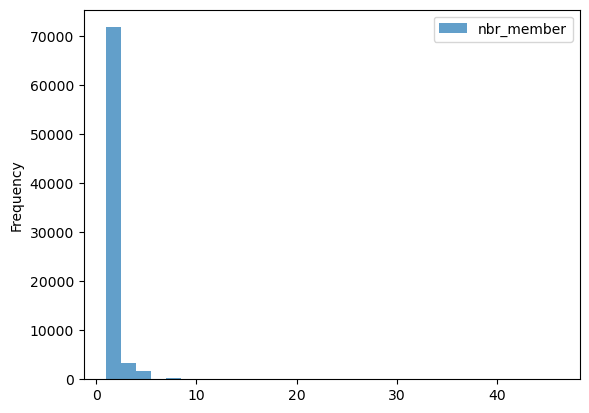

In [31]:
x.plot.hist(bins=30, alpha=0.7)

_**Observation:**_ Groups with only one participant should be excluded in the stat summary.

array([[<Axes: title={'center': 'n_grp'}>,
        <Axes: title={'center': 'nbr_connection'}>]], dtype=object)

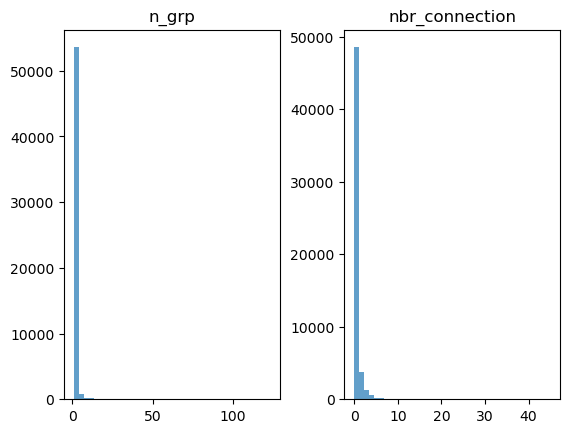

In [32]:
# for every user, count the unique users across _all_ associated groups

cnx = mbr.groupby('user_id').agg({'group_id': 'nunique', 'member_id':'nunique'})
cnx.columns = ['n_grp', 'nbr_connection']
cnx['nbr_connection'] = cnx['nbr_connection'] - 1 # remove user itself from count
cnx.hist(bins=40, grid=False, alpha=.7)

## Merge and Impute

In [33]:
td = users.merge(tenure, on='user_id', how='right') \
    .merge(cnx['nbr_connection'], on='user_id', how='left') \
    .merge(td_grp, on='user_id', how='left') \
    .convert_dtypes()
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399110 entries, 0 to 399109
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype          
---  ------           --------------   -----          
 0   user_id          399110 non-null  string         
 1   is_bot           397394 non-null  boolean        
 2   registered       397394 non-null  datetime64[ns] 
 3   user_tenure      399110 non-null  timedelta64[ns]
 4   first_entry      399110 non-null  datetime64[ns] 
 5   last_entry       399110 non-null  datetime64[ns] 
 6   nbr_entry        399110 non-null  Int64          
 7   total_exp        399110 non-null  Int64          
 8   nbr_exp          399110 non-null  Int64          
 9   total_inc        399110 non-null  Int64          
 10  nbr_inc          399110 non-null  Int64          
 11  nbr_connection   54836 non-null   Int64          
 12  n_grp            54836 non-null   Int64          
 13  first_grp_entry  54836 non-null   datetime64[ns] 
 14  last

In [34]:
values = {'is_bot':False,
          'nbr_connection':0, 'n_grp':0,
          'grp_exp':0, 'nbr_grp_exp':0,
          'grp_inc':0, 'nbr_grp_inc':0}
td.fillna(value=values, inplace=True)

In [35]:
td.describe()

,registered,user_tenure,first_entry,last_entry,nbr_entry,total_exp,nbr_exp,total_inc,nbr_inc,nbr_connection,n_grp,first_grp_entry,last_grp_entry,grp_exp,nbr_grp_exp,grp_inc,nbr_grp_inc
count,397394,399110,399110,399110,399110.0,399110.0,399110.0,399110.0,399110.0,399110.0,399110.0,54836,54836,399110.0,399110.0,399110.0,399110.0
mean,2019-11-28 01:26:46.906999808,213 days 07:32:40.223497284,2020-01-10 11:32:41.883190016,2020-08-10 19:05:22.106687744,88.198735,-126604.914555,82.565581,145287.6125,5.633154,0.138513,0.194032,2021-02-27 15:53:23.997374208,2021-09-02 06:59:58.686993920,-20760.730255,12.645922,16468.0427,1.007868
min,2018-06-01 00:00:00,0 days 00:00:00,2018-06-01 00:00:00,2018-06-03 00:00:00,1.0,-4135128073.0,0.0,0.0,0.0,0.0,0.0,2018-06-01 00:00:00,2018-06-06 00:00:00,-299999997.0,0.0,0.0,0.0
25%,2018-09-25 00:00:00,0 days 00:00:00,2018-10-01 00:00:00,2018-12-07 00:00:00,2.0,-16033.0,2.0,0.0,0.0,0.0,0.0,2019-03-08 00:00:00,2019-09-02 18:00:00,0.0,0.0,0.0,0.0
50%,2019-03-28 00:00:00,7 days 00:00:00,2019-06-29 00:00:00,2019-12-17 00:00:00,7.0,-2336.5,7.0,0.0,0.0,0.0,0.0,2021-01-05 00:00:00,2021-08-25 00:00:00,0.0,0.0,0.0,0.0
75%,2020-06-29 00:00:00,139 days 00:00:00,2020-10-05 00:00:00,2021-12-12 00:00:00,32.0,-327.0,29.0,9997.5,1.0,0.0,0.0,2023-01-01 00:00:00,2023-07-04 00:00:00,0.0,0.0,0.0,0.0
max,2025-02-07 00:00:00,2436 days 00:00:00,2025-01-31 00:00:00,2025-01-31 00:00:00,35515.0,0.0,25720.0,5959084893.0,26923.0,45.0,123.0,2025-01-31 00:00:00,2025-01-31 00:00:00,0.0,23868.0,377401583.0,5852.0
std,NaN,452 days 19:06:48.118525888,NaN,NaN,417.039147,8975724.512895,382.715875,13838559.350852,102.54491,0.719068,0.752187,NaN,NaN,812351.631476,138.585961,893077.362518,25.546265


In [36]:
# raise exception if file already exists but allow the run to proceed
td.to_csv('../reports/tidy.csv', mode='x')

# EDA

## Bots

In [37]:
td[td.is_bot].describe()

,registered,user_tenure,first_entry,last_entry,nbr_entry,total_exp,nbr_exp,total_inc,nbr_inc,nbr_connection,n_grp,first_grp_entry,last_grp_entry,grp_exp,nbr_grp_exp,grp_inc,nbr_grp_inc
count,198,198,198,198,198.0,198.0,198.0,198.0,198.0,198.0,198.0,0,0,198.0,198.0,198.0,198.0
mean,2022-07-03 22:18:10.909090816,555 days 07:23:38.181818184,2022-07-09 21:34:32.727272704,2024-01-16 04:58:10.909090816,45.338384,-2946.994949,45.338384,0.0,0.0,0.0,0.0,NaT,NaT,0.0,0.0,0.0,0.0
min,2022-02-15 00:00:00,8 days 00:00:00,2022-02-17 00:00:00,2023-07-13 00:00:00,2.0,-4940.0,2.0,0.0,0.0,0.0,0.0,NaT,NaT,0.0,0.0,0.0,0.0
25%,2022-02-15 00:00:00,535 days 06:00:00,2022-02-20 00:00:00,2023-11-29 00:00:00,41.0,-3835.0,41.0,0.0,0.0,0.0,0.0,NaT,NaT,0.0,0.0,0.0,0.0
50%,2022-05-11 00:00:00,617 days 00:00:00,2022-05-20 00:00:00,2024-01-15 12:00:00,51.5,-3347.5,51.5,0.0,0.0,0.0,0.0,NaT,NaT,0.0,0.0,0.0,0.0
75%,2022-05-27 00:00:00,697 days 00:00:00,2022-05-29 18:00:00,2024-02-29 12:00:00,59.0,-2665.0,59.0,0.0,0.0,0.0,0.0,NaT,NaT,0.0,0.0,0.0,0.0
max,2023-07-03 00:00:00,830 days 00:00:00,2023-08-09 00:00:00,2024-06-01 00:00:00,76.0,-130.0,76.0,0.0,0.0,0.0,0.0,NaT,NaT,0.0,0.0,0.0,0.0
std,NaN,209 days 20:56:49.447345904,NaN,NaN,18.695575,1215.212348,18.695575,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0


_**Observation:**_ Nothing too interesting to note

In [38]:
# dropping Bots from future analysis steps
td.drop(td[td.is_bot].index, axis=0, inplace=True)

## Group of One


In [39]:
x = mbr.groupby('group_id').agg(n_member=('member_id', 'nunique'))
y = x.query('n_member == 1')
grp_lst = [i[1] for i in y.index]
cashflow[(cashflow.amt != 0) & (cashflow.group_id.isin(grp_lst))].groupby('group_id') \
    .agg(first_entry=('date', 'min'), last_entry=('date', 'max'),
         nbr_entry=('amt', 'count'),
         grp_exp = ('amt', lambda x: x[x < 0].sum()),
         nbr_grp_exp = ('amt', lambda x: x[x < 0].count()),
         grp_inc = ('amt', lambda x: x[x > 0].sum()),
         nbr_grp_inc = ('amt', lambda x: x[x > 0].count())
        ) \
    .describe()

,first_entry,last_entry,nbr_entry,grp_exp,nbr_grp_exp,grp_inc,nbr_grp_inc
count,0,0,0.0,0.0,0.0,0.0,0.0
mean,NaT,NaT,<NA>,<NA>,<NA>,<NA>,<NA>
min,NaT,NaT,<NA>,<NA>,<NA>,<NA>,<NA>
25%,NaT,NaT,<NA>,<NA>,<NA>,<NA>,<NA>
50%,NaT,NaT,<NA>,<NA>,<NA>,<NA>,<NA>
75%,NaT,NaT,<NA>,<NA>,<NA>,<NA>,<NA>
max,NaT,NaT,<NA>,<NA>,<NA>,<NA>,<NA>
std,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>


In [40]:
# len(grp_lst) / x.shape[0]
# x.shape[0]
#len(set([i[1] for i in x.index]))
# mbr.group_id = mbr.group_id.str.strip()
mbr[mbr.group_id.str.len() == 0]

,user_id,group_id,member_id


## Survival Analysis
Survival, i.e., churns

In [41]:
t0 = pd.to_datetime(td.last_entry.max())
td['days_since'] = t0 - td.last_entry
td[['last_entry', 'user_tenure', 'days_since']].describe()

,last_entry,user_tenure,days_since
count,398912,398912,398912
mean,2020-08-10 04:09:29.990373888,213 days 03:28:13.943526396,1634 days 19:50:30.009626224
min,2018-06-03 00:00:00,0 days 00:00:00,0 days 00:00:00
25%,2018-12-07 00:00:00,0 days 00:00:00,1148 days 00:00:00
50%,2019-12-16 00:00:00,7 days 00:00:00,1873 days 00:00:00
75%,2021-12-10 00:00:00,138 days 00:00:00,2247 days 00:00:00
max,2025-01-31 00:00:00,2436 days 00:00:00,2434 days 00:00:00
std,NaN,452 days 19:41:40.353128168,705 days 03:50:55.330611240


_**Oberservations:**_
- 50% of users churned after 7 days, 75% churned after 139 days (or ~4.6 months)
- 75% of users had not made any entries for >1146 days
- top quartile (best or most active users) had made at least one entries since 2021-12-12 (or 48~50 days)

In [42]:
# what do you observe from the top quartile...

t0 = td.days_since.quantile(.25) # 1146 days since last entry
print('days_since =', t0.days)
(td.loc[td.days_since < t0, ['days_since', 'user_tenure', 'nbr_entry', 'last_entry']].describe())

days_since = 1148


,days_since,user_tenure,nbr_entry,last_entry
count,99708,99708,99708.0,99708
mean,584 days 18:16:13.980021664,564 days 05:29:19.489709944,249.904812,2023-06-26 05:43:46.019978240
min,0 days 00:00:00,0 days 00:00:00,1.0,2021-12-11 00:00:00
25%,232 days 00:00:00,2 days 00:00:00,4.0,2022-07-15 00:00:00
50%,606 days 00:00:00,108 days 00:00:00,20.0,2023-06-05 00:00:00
75%,931 days 00:00:00,1128 days 00:00:00,107.0,2024-06-13 00:00:00
max,1147 days 00:00:00,2436 days 00:00:00,35515.0,2025-01-31 00:00:00
std,376 days 21:05:25.086325004,717 days 15:09:06.702442152,787.441482,NaN


## Segmentation by `days_since` and Tenure
- `days_since` is the number of days since the user has made the last entry
- Tenure is the number of days between the users first and last date of expense or income entry

In [43]:
[(x.left.round('D').days, x.right.days) for x in pd.qcut(td.days_since, q=20).unique().sort_values()]

[(0, 175),
 (175, 468),
 (468, 726),
 (726, 998),
 (998, 1148),
 (1148, 1334),
 (1334, 1487),
 (1487, 1635),
 (1635, 1782),
 (1782, 1873),
 (1873, 1963),
 (1963, 2024),
 (2024, 2116),
 (2116, 2199),
 (2199, 2247),
 (2247, 2278),
 (2278, 2314),
 (2314, 2321),
 (2321, 2404),
 (2404, 2434)]

In [44]:
[(round(x.left), round(x.right)) for x in pd.qcut(td.user_tenure.dt.days, q=20, duplicates='drop').unique().sort_values()]
# td.info()

[(0, 1),
 (1, 2),
 (2, 4),
 (4, 7),
 (7, 12),
 (12, 20),
 (20, 36),
 (36, 69),
 (69, 138),
 (138, 280),
 (280, 496),
 (496, 815),
 (815, 1307),
 (1307, 2436)]

In [45]:
df = td.loc[(td.days_since < td.days_since.quantile(.25)) &
            (td.user_tenure > td.user_tenure.quantile(.5)),
            ['user_id', 'days_since', 'user_tenure']].copy()
df.describe()

,days_since,user_tenure
count,67717,67717
mean,546 days 18:06:23.088441608,830 days 06:50:06.973138216
std,382 days 09:26:54.369649956,733 days 06:10:33.115359160
min,0 days 00:00:00,8 days 00:00:00
25%,177 days 00:00:00,94 days 00:00:00
50%,560 days 00:00:00,708 days 00:00:00
75%,894 days 00:00:00,1423 days 00:00:00
max,1147 days 00:00:00,2436 days 00:00:00


In [46]:
df['days_since_decile'] = pd.qcut(df.days_since.dt.days, q=10)
df['days_since_decile'] = df['days_since_decile'].apply(lambda x: (x.right).astype('int') )  
df['user_tenure_decile'] = pd.qcut(df.user_tenure.dt.days, q=10)
df['user_tenure_decile'] = df['user_tenure_decile'].apply(lambda x: round(x.right)) 

In [47]:
df.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9])

,days_since,user_tenure
count,67717,67717
mean,546 days 18:06:23.088441608,830 days 06:50:06.973138216
std,382 days 09:26:54.369649956,733 days 06:10:33.115359160
min,0 days 00:00:00,8 days 00:00:00
10%,7 days 00:00:00,22 days 00:00:00
20%,109 days 00:00:00,56 days 00:00:00
30%,250 days 00:00:00,154 days 00:00:00
40%,417 days 00:00:00,378 days 00:00:00
50%,560 days 00:00:00,708 days 00:00:00
60%,701 days 00:00:00,1032 days 00:00:00


days_since_decile,7,109,250,417,560,701,823,966,1072,1147
count,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,9.000000,9.000000,8.000000,8.00000
mean,677.900000,678.400000,676.900000,678.800000,674.100000,755.777778,752.444444,754.000000,845.750000,841.25000
std,638.468036,410.679708,313.181328,196.732644,337.482329,207.850173,150.362155,372.088699,195.810222,372.51069
min,125.000000,365.000000,364.000000,424.000000,183.000000,557.000000,592.000000,33.000000,592.000000,213.00000
25%,373.750000,460.750000,461.750000,563.750000,559.500000,639.000000,662.000000,701.000000,733.500000,651.00000
50%,538.000000,555.000000,660.500000,603.000000,636.500000,713.000000,733.000000,756.000000,792.500000,846.50000
75%,658.250000,728.500000,736.500000,740.750000,718.750000,759.000000,828.000000,793.000000,918.500000,1044.50000
max,2388.000000,1775.000000,1438.000000,1045.000000,1510.000000,1255.000000,1075.000000,1512.000000,1215.000000,1446.00000


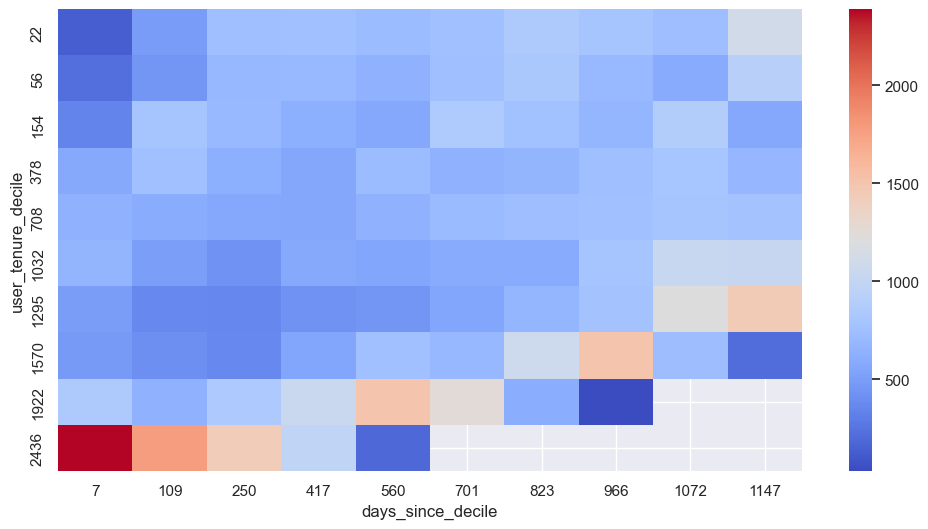

In [48]:
import seaborn as sns

df_plot = df.groupby(['days_since_decile', 'user_tenure_decile'], observed=True).agg({'user_id':'count'}).reset_index()
df_plot = df_plot.pivot(index='user_tenure_decile', columns='days_since_decile', values='user_id')

# Set figure size globally
sns.set_theme(rc={'figure.figsize': (12, 6)})

_ = sns.heatmap(df_plot, annot=False, cmap='coolwarm')
df_plot.describe()

## Explore Group 

In [49]:
#number of members in each group
nbr_mbr_grp = grp.groupby('group_id')['user_id'].nunique()

nbr_mbr_grp.agg(['min', 'max', 'mean', 'median'])

min        1.00000
max       46.00000
mean       1.48415
median     1.00000
Name: user_id, dtype: float64

In [50]:
nbr_mbr_grp.quantile([.25, .5, .75, .8, .9, .95, .99])

0.25    1.0
0.50    1.0
0.75    2.0
0.80    2.0
0.90    2.0
0.95    2.0
0.99    3.0
Name: user_id, dtype: float64

In [51]:
# is this interesting?

cashflow.groupby(['user_id'])['amt'].sum().quantile([.1, .25, .5, .75, .9])

0.10   -25265.0
0.25    -4000.0
0.50     -381.0
0.75      645.0
0.90    18975.0
Name: amt, dtype: Float64

## Expense by Category



In [52]:
# private entries
cashflow.query("is_group == False & is_expense == True").groupby('category') \
    .agg(n_user = ('user_id','nunique'),
         nbr_expense = ('category', 'count'),
         nbr_expense_per_user = ('user_id', lambda x: round(x.count() / x.nunique(), 2)),
         avg_amt = ('amt', lambda x: -(round(x.mean())))
        ) \
    .sort_values(by='nbr_expense',  ascending=False)

,n_user,nbr_expense,nbr_expense_per_user,avg_amt
category,,,,
飲食,308382,16075898,52.13,577
日常,142490,2321898,16.30,1817
交通,147978,2158314,14.59,1113
其他,162369,1794741,11.05,3261
娛樂,121251,1168411,9.64,4683
...,...,...,...,...
平面學費,1,1,1.00,3300
肉毒,1,1,1.00,6990
肉泥,1,1,1.00,560


In [53]:
# group entries
cashflow.query("is_group == True & is_expense == True").groupby('category') \
    .agg(n_user = ('user_id','nunique'),
         nbr_expense = ('category', 'count'),
         nbr_expense_per_user = ('user_id', lambda x: round(x.count() / x.nunique(), 2)),
         avg_amt = ('amt', lambda x: -(round(x.mean())))
        ) \
    .sort_values(by='nbr_expense',  ascending=False)

,n_user,nbr_expense,nbr_expense_per_user,avg_amt
category,,,,
飲食,40004,2621626,65.53,415
日常,22243,436159,19.61,2328
交通,22558,363136,16.10,1123
其他,22810,276679,12.13,5418
娛樂,19443,177804,9.14,3634
...,...,...,...,...
嗚嗚,1,1,1.00,12600
嗡嗡,1,1,1.00,3000
美村,1,1,1.00,37350


# Supplemental

```sql
-- consolidate expense and income entry to simplify analysis

USE zoo;

DROP TABLE IF EXISTS acc_cashflow;

CREATE TABLE acc_cashflow (
  user_id VARCHAR(100) NOT NULL,
  date DATE NOT NULL,
  amt DOUBLE NOT NULL,
  is_expense BOOLEAN,
	is_group BOOLEAN,
  group_id VARCHAR(100),
  category_id INT,
  category VARCHAR(100),
  note VARCHAR(160)
) COMMENT = 'consolidated expense and income entries'
;

-- insert personal expense
INSERT INTO acc_cashflow
SELECT
  USER_ID user_id,
  DATE(CREDTM) date,
  -AMOUNT amt,
  TRUE is_expense,
	FALSE is_group,
  NULL group_id,
  A.CATEGORY category_id,
  B.CATEGORY category,
  NOTE note
FROM zoo.ACC_USER_DETAIL A
LEFT JOIN zoo_checkchick3.ACC_CATEGORY B
ON A.CATEGORY = B.ID
;

-- insert group expense
INSERT INTO acc_cashflow
SELECT
  USER_ID user_id,
  DATE(CREDTM) date,
  -AMOUNT amt,
  TRUE is_expense,
	TRUE is_group,
  GROUP_ID group_id,
  A.CATEGORY category_id,
  B.CATEGORY category,
  NOTE note
FROM zoo_checkchick.ACC_GROUP_DETAIL A
LEFT JOIN zoo_checkchick3.ACC_CATEGORY B
ON A.CATEGORY = B.ID
;

-- insert personal income
INSERT INTO acc_cashflow
SELECT
  USER_ID user_id,
  DATE(CREDTM) date,
  AMOUNT amt,
  FALSE is_expense,
	FALSE is_group,
  NULL group_id,
  A.CATEGORY category_id,
  B.CATEGORY category,
  NOTE note
FROM zoo_checkchick2.ACC_USER_DETAIL_INCOME A
LEFT JOIN zoo_checkchick3.ACC_CATEGORY_INCOME B
ON A.CATEGORY = B.ID
;

-- insert group income
INSERT INTO acc_cashflow
SELECT
  USER_ID user_id,
  DATE(CREDTM) date,
  AMOUNT amt,
  FALSE is_expense,
	TRUE is_group,
  GROUP_ID group_id,
  A.CATEGORY category_id,
  B.CATEGORY category,
  NOTE note
FROM zoo_checkchick2.ACC_GROUP_DETAIL_INCOME A
LEFT JOIN zoo_checkchick3.ACC_CATEGORY_INCOME B
ON A.CATEGORY = B.ID
;
```